In [1]:
import os
import sys
import pandas as pd
# !{sys.executable} -m pip install python-csv
# !{sys.executable} -m pip install --upgrade pip
# !{sys.executable} -m pip install pandas;
# print(pd.__version__)

from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import pandas as pd
import math 

from lib.data_formatter import DataFormatter
from lib.database import Database
from lib.display import Display
from lib.participant_builder import ParticipantsBuilder
from lib.schema import Schema
from lib.studies.cronos_study import CronosStudy

study = CronosStudy()

In [2]:
db = Database(Schema.CRONOS)   
Display.header('CRONOS+ study on ALP', 'h1')

Display.header('Participants', 'h3')
participants_df = db.get_participants()
Display.frame(participants_df, 5)
print('Number of participants:', participants_df.shape[0])

Display.header('Responses', 'h3')
responses_df = db.get_responses()
Display.frame(responses_df.drop(columns=['QUESTIONNAIRE_ID']), 5)
print('Number of responses:', responses_df.shape[0])

,ALP_ID,EXTERNAL_ID,STATUS,START_DATE,END_DATE
1,1505,anonymous,enrolled,2021-05-19,NaT
2,13287,anonymous,enrolled,2022-04-29,NaT
3,10814,Klinikum-Dortmund-44,enrolled,2022-02-11,NaT
4,11521,anonymous,enrolled,2022-02-21,NaT
5,13114,anonymous,enrolled,2022-04-12,NaT


Number of participants: 490


,ALP_ID,VERSION,AUTHORED,QUESTIONNAIRE,LINK_ID,VALUE,VALUECODING_CODE,LANGUAGE,TEXT
1,3,1.0.0,2022-09-21,Q6_handling_challenges,opinion_recover_setbacks_is_hard,NaN,agree_partial,de,"Ich brauche tendenziell lange, um Ã¼ber RÃ¼ckschlÃ¤ge in meinem Leben hinwegzukommen."
2,3,1.0.0,2022-09-21,Q6_handling_challenges,opinion_recover_problems_is_easy,NaN,agree_strong,de,Normalerweise Ã¼berstehe ich schwierige Zeiten ohne grÃ¶Ãere Probleme.
3,3,1.0.0,2022-09-21,Q6_handling_challenges,opinion_recover_bad_situation_is_hard,NaN,disagree,de,"Es fÃ¤llt mir schwer zur NormalitÃ¤t zurÃ¼ckzukehren, wenn etwas Schlimmes passiert ist."
4,3,1.0.0,2022-09-21,Q6_handling_challenges,opinion_recover_stress_is_easy,NaN,disagree,de,"Ich brauche nicht viel Zeit, um mich von einem stressigen Ereignis zu erholen."
5,3,1.0.0,2022-09-21,Q6_handling_challenges,opinion_deal_with_stress_is_hard,NaN,disagree,de,"Es fÃ¤llt mir schwer, stressige Situationen durchzustehen."


Number of responses: 33806


In [3]:
date_str = responses_df['AUTHORED'].max().strftime("%Y-%m-%d")

r_df = responses_df.copy()
r_df['TEXT'] = r_df['TEXT'].replace('\\n',' ', regex=True)
r_df['VALUE'] = r_df['VALUE'].replace('\\n',' ', regex=True)
r_df.to_csv(f'files/CRONOS/{date_str}-responses.csv', index=False)  
participants_df.to_csv(f'files/CRONOS/{date_str}-participants.csv', index=False)  

Number of clinics:		 11
Number of participants:		 145


Users enrolled after 25.09.2021:	 295
Users enrolled before 25.09.2021:	 9


Number of recruited users with external_id=null: 0
Number of test users: 26


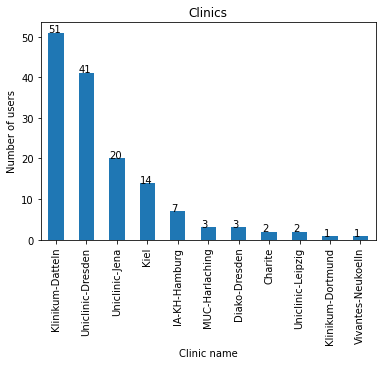

In [4]:
df = participants_df[(participants_df['EXTERNAL_ID'] != 'anonymous') & 
                     ~participants_df['EXTERNAL_ID'].str.contains('test')].copy()

df['USERS'] = df['EXTERNAL_ID'].apply(lambda x: '-'.join(x.split('-')[:-1]))
value_counts = df['USERS'].value_counts()

Display.header(f'All users', 'h1')
Display.header(f'Users recruted by DGPM', 'h3')

fig1, (ax1) = plt.subplots(1,1, figsize=(6,4))
value_counts.plot(kind="bar", ylabel='Number of users', xlabel='Clinic name', title='Clinics', ax=ax1);
Display.tag_bars(ax1)

print(f'Number of clinics:\t\t {len(value_counts)}')
print(f'Number of participants:\t\t {value_counts.sum()}')

df = participants_df[participants_df['EXTERNAL_ID'] == 'anonymous']
thereshold = datetime(2021, 9, 25)

Display.header(f'Users without token', 'h3')
df1 = df[df['START_DATE'] >= thereshold]
print(f'Users enrolled after {thereshold.strftime("%d.%m.%Y")}:\t {len(df1)}')
df2 = df[df['START_DATE'] < thereshold]
print(f'Users enrolled before {thereshold.strftime("%d.%m.%Y")}:\t {len(df2)}')

Display.header(f'Test users', 'h3')
df3 = participants_df[pd.isnull(participants_df['EXTERNAL_ID'])]
print(f'Number of recruited users with external_id=null: {len(df3)}')
df4 = participants_df[participants_df['EXTERNAL_ID'].str.contains('test')]
print(f'Number of test users: {len(df4)}')

In [5]:
study = CronosStudy()
builder = ParticipantsBuilder(study, participants_df, responses_df)
df = builder.filter_data4life_users() \
    .filter_annonymous_users() \
    .add_last_donation() \
    .add_all_submissions() \
    .add_answer('Q1_personal_info', 'when_expected_delivery', 'EXPECTED_BIRTH') \
    .add_answer(None, 'when_delivery_date', 'ACTUAL_BIRTH') \
    .get()

def days_after_delivery(row):
    return (datetime.now() - datetime.strptime(row['EXPECTED_BIRTH'], "%Y-%m-%d")).days if row['DELIVERED'] else 0

def calculate_expected_q3(row):
    if pd.isnull(row['ENROLED_ON']) : return 0
    last_donation = datetime.now() - timedelta(days=datetime.now().weekday())
    days = (last_donation - row['ENROLED_ON']).days - row['DAYS_AFTER_DELIVERY']
    if days < 7:
        return 0
    return 1 + math.floor((days - 7) / 28) 

df['DELIVERED'] = datetime.now() >= pd.to_datetime(df['EXPECTED_BIRTH'], format="%Y-%m-%d")
df['DAYS_AFTER_DELIVERY'] = df.apply(lambda row : days_after_delivery(row), axis = 1)
df['expected:Q3'] = df.apply(lambda row : calculate_expected_q3(row), axis = 1)
df['expected:Q5'] = (datetime.now() - pd.to_datetime(df['EXPECTED_BIRTH'], format="%Y-%m-%d")).dt.days > 42

Display.header('Submissions table', 'h2')
Display.frame(df, 5)

,ALP_ID,EXTERNAL_ID,STATUS,START_DATE,END_DATE,ENROLED_ON,LAST_DONATION,all,Q1,Q2a,Q2b,Q3,Q3a,Q3b,Q6,Q5,EXPECTED_BIRTH,ACTUAL_BIRTH,DELIVERED,DAYS_AFTER_DELIVERY,expected:Q3,expected:Q5
0,10814,Klinikum-Dortmund-44,enrolled,2022-02-11,NaT,2022-02-11,2022-02-11,3,1,1,0,0,0,0,1,0,2022-02-02,NaN,True,260,0,True
1,11706,IA-KH-Hamburg-19,enrolled,2022-02-28,NaT,2022-02-28,2022-05-10,8,1,1,1,1,1,2,1,0,2022-03-31,2022-03-28,True,203,1,True
2,2475,Uniclinic-Dresden-05,enrolled,2021-05-08,NaT,2021-05-08,2021-08-05,9,1,1,1,2,1,1,1,1,2021-06-29,2021-06-24,True,478,2,True
3,11523,IA-KH-Hamburg-03,enrolled,2022-02-23,NaT,2022-02-23,2022-04-11,7,1,1,1,1,0,2,1,0,2022-03-26,2022-02-28,True,208,1,True
4,9828,Uniclinic-Dresden-23,enrolled,2022-01-18,NaT,2022-01-18,2022-03-21,8,1,1,1,1,1,2,1,0,2022-02-13,2022-02-07,True,249,1,True


In [6]:
temp = df[['ALP_ID', 'EXTERNAL_ID', 'ENROLED_ON', 'LAST_DONATION', 'DELIVERED', 'Q5']].copy()
temp['TIME'] = temp['LAST_DONATION'] - temp['ENROLED_ON'] 
temp.rename(columns={'Q5': 'FINISHED'}, inplace=True)

Display.header('Participants: in-progress, post delivery, finished study', 'h2')
Display.frame(temp, 5)

,ALP_ID,EXTERNAL_ID,ENROLED_ON,LAST_DONATION,DELIVERED,FINISHED,TIME
0,10814,Klinikum-Dortmund-44,2022-02-11,2022-02-11,True,0,0 days
1,11706,IA-KH-Hamburg-19,2022-02-28,2022-05-10,True,0,71 days
2,2475,Uniclinic-Dresden-05,2021-05-08,2021-08-05,True,1,89 days
3,11523,IA-KH-Hamburg-03,2022-02-23,2022-04-11,True,0,47 days
4,9828,Uniclinic-Dresden-23,2022-01-18,2022-03-21,True,0,62 days


In [7]:
Display.header('Delivery date: Expected vs Actual', 'h2')
result = df[['EXPECTED_BIRTH', 'ACTUAL_BIRTH', 'ENROLED_ON', 'LAST_DONATION']]
Display.frame(result, 5)

,EXPECTED_BIRTH,ACTUAL_BIRTH,ENROLED_ON,LAST_DONATION
0,2022-02-02,NaN,2022-02-11,2022-02-11
1,2022-03-31,2022-03-28,2022-02-28,2022-05-10
2,2021-06-29,2021-06-24,2021-05-08,2021-08-05
3,2022-03-26,2022-02-28,2022-02-23,2022-04-11
4,2022-02-13,2022-02-07,2022-01-18,2022-03-21


In [8]:
df = result.copy()
df['date_expected'] = pd.to_datetime(df['EXPECTED_BIRTH']).dt.to_period('m')
df['date_actual'] = pd.to_datetime(df['ACTUAL_BIRTH']).dt.to_period('m')

df1 = df.groupby(by=['date_expected']).count().sort_index()[['EXPECTED_BIRTH']].reset_index().rename(columns = {'date_expected': 'date'})
df2 = df.groupby(by=['date_actual']).count().sort_index()[['ACTUAL_BIRTH']].reset_index().rename(columns = {'date_actual': 'date'})
df = pd.merge(df1, df2, how='outer', on=['date']) 

Display.header('Expected/Actual births per month', 'h2')
df.head()

,date,EXPECTED_BIRTH,ACTUAL_BIRTH
0,2021-06,1,1.0
1,2021-07,1,1.0
2,2021-08,2,3.0
3,2021-09,3,2.0
4,2021-10,1,1.0


Current week is: 42,2022


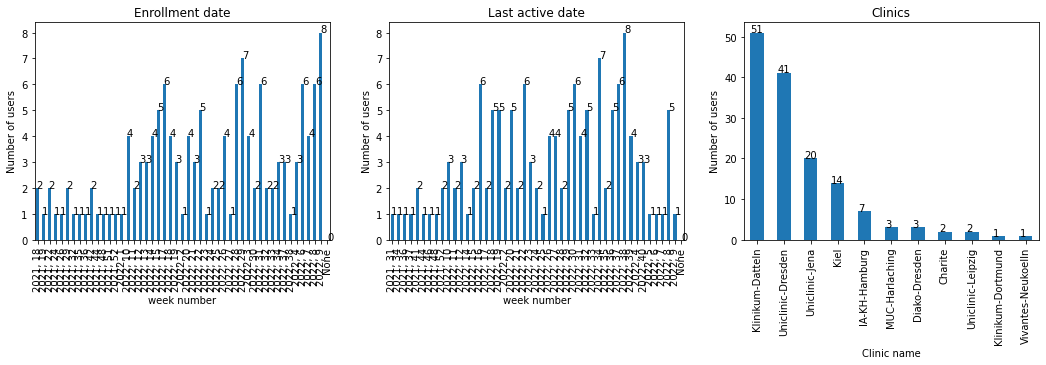

In [9]:
from matplotlib import pyplot as plt
import math

def to_week_number(day):
    if pd.isnull(day): return 'None'
    week_now = day.date().isocalendar()[1]
    year_now = day.date().isocalendar()[0]
    return f'{year_now}, {week_now}'

def count_on_timeline(data, column_name):
    df = data[[column_name]].copy()
    df['week_number'] = df[column_name].apply(lambda x: to_week_number(x))
    return df.groupby(by=['week_number']).count().sort_index()
    
def get_current_week():    
    week_now = datetime.now().date().isocalendar()[1]
    year_now = datetime.now().date().isocalendar()[0]
    return f'{week_now},{year_now}'

def tag_bars(ax, size=None):
    for p in ax.patches:
        value = f'{round(100 * p.get_height() / size, 2)}%' if size else f'{p.get_height()}'
        ax.annotate(value, (p.get_x() * 1.005, p.get_height() * 1.005))
        
Display.header('Participants enrollment', 'h1')
Display.header('Participants with a token', 'h2')
print('Current week is:', get_current_week())

fig1, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(18,4))

df = result.copy()
value_counts = count_on_timeline(df, 'ENROLED_ON')
value_counts.plot(kind="bar", ylabel='Number of users', xlabel='week number', title='Enrollment date', legend=None, ax=ax1)

value_counts = count_on_timeline(df, 'LAST_DONATION')
value_counts.plot(kind="bar", ylabel='Number of users', xlabel='week number', title='Last active date', legend=None, ax=ax2);

builder = ParticipantsBuilder(study, participants_df, responses_df)
df = builder.filter_data4life_users() \
    .filter_annonymous_users() \
    .add_last_donation() \
    .get()

df[['CLINIC','PATIENT_ID']] = df['EXTERNAL_ID'].str.rsplit('-', expand=True, n=1)
value_counts = df['CLINIC'].value_counts()
value_counts.plot(kind="bar", ylabel='Number of users', xlabel='Clinic name', title='Clinics', ax=ax3);

for ax in [ax1,ax2,ax3]:
    tag_bars(ax)

Current week is: 42,2022


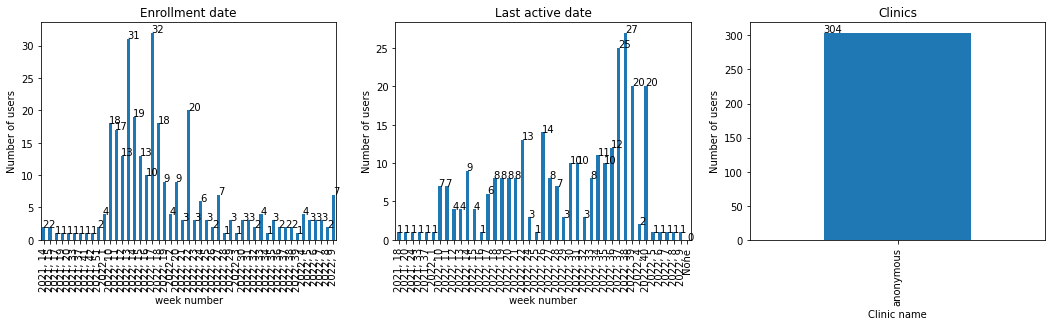

In [10]:
study = CronosStudy()
builder = ParticipantsBuilder(study, participants_df, responses_df)
df = builder.add_last_donation() \
    .add_all_submissions() \
    .add_answer('Q1_personal_info', 'when_expected_delivery', 'EXPECTED_BIRTH') \
    .add_answer(None, 'when_delivery_date', 'ACTUAL_BIRTH') \
    .get()

df = df[(df['EXTERNAL_ID'] == 'anonymous') & \
        (~pd.isnull(df['START_DATE']))] \
        .sort_values(by=['START_DATE'], ascending=False)

fig1, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(18,4))

value_counts = count_on_timeline(df, 'START_DATE')
value_counts.plot(kind="bar", ylabel='Number of users', xlabel='week number', title='Enrollment date', legend=None, ax=ax1)

value_counts = count_on_timeline(df, 'LAST_DONATION')
value_counts.plot(kind="bar", ylabel='Number of users', xlabel='week number', title='Last active date', legend=None, ax=ax2);

builder = ParticipantsBuilder(study, participants_df, responses_df)

Display.header('Annonymous participants (without a token)', 'h2')
print('Current week is:', get_current_week())

value_counts = df['EXTERNAL_ID'].value_counts()
value_counts.plot(kind="bar", ylabel='Number of users', xlabel='Clinic name', title='Clinics', ax=ax3);

for ax in [ax1,ax2,ax3]:
    tag_bars(ax)

In [11]:
from datetime import datetime, timedelta, date

def get_eariest_responding_time(data, questionnaire_name, column_name):
    df = data[data['QUESTIONNAIRE'] == questionnaire_name]
    df = df[['ALP_ID', 'AUTHORED']]
    df = df.groupby(by=['ALP_ID']).agg({'AUTHORED': ['min']})
    df.reset_index(inplace=True)
    df.columns = ['ALP_ID', column_name]
    return df

p_df = ParticipantsBuilder(study, participants_df, responses_df) \
    .filter_data4life_users() \
    .filter_annonymous_users() \
    .add_last_donation() \
    .add_all_submissions() \
    .add_answer('Q1_personal_info', 'when_expected_delivery', 'EXPECTED_BIRTH') \
    .add_answer(None, 'when_delivery_date', 'ACTUAL_BIRTH') \
    .get()[['ALP_ID', 'EXTERNAL_ID', 'ENROLED_ON', 'LAST_DONATION', 'ACTUAL_BIRTH', 'EXPECTED_BIRTH', 'Q3', 'Q3a', 'Q2b', 'Q5']]

p_df['ACTUAL_BIRTH'] = pd.to_datetime(p_df['ACTUAL_BIRTH'], format='%Y-%m-%d', errors='coerce')
p_df['FINISH'] = p_df['ACTUAL_BIRTH'] + timedelta(days=6*7)
p_df['TIME'] = p_df['LAST_DONATION'] - p_df['ENROLED_ON']

ids = p_df['ALP_ID'].unique()
relevant_responses = responses_df[responses_df['ALP_ID'].isin(ids)]

def add_q3_instance(result, n):
    if n == 1:
        result = get_eariest_responding_time(relevant_responses, 'Q3_mood_in_pregnancy', 'Q3_x1')
        return pd.merge(p_df, result, how='left', on=['ALP_ID'])
    df = relevant_responses.copy()
    df = pd.merge(df, result, how='left', on=['ALP_ID']) 
    cond = df['AUTHORED'] != df[f'Q3_x1']
    for i in range(2,n):
        cond = cond & (df['AUTHORED'] != df[f'Q3_x{i}'])
    df = df[cond]
    df = get_eariest_responding_time(df, 'Q3_mood_in_pregnancy', f'Q3_x{n}')
    return pd.merge(result, df, how='left', on=['ALP_ID']) 

# last Monday
last_donation = datetime.now() - timedelta(days=date.today().weekday())

p_df['DELIVERED'] = datetime.now() >= pd.to_datetime(p_df['EXPECTED_BIRTH'], format="%Y-%m-%d")
p_df['DAYS_AFTER_DELIVERY'] = p_df.apply(lambda row : days_after_delivery(row), axis = 1)
p_df['expected:Q3'] = p_df.apply(lambda row : calculate_expected_q3(row), axis = 1)
p_df['expected:Q5'] = (last_donation - pd.to_datetime(p_df['EXPECTED_BIRTH'], format="%Y-%m-%d")).dt.days > 42
p_df.drop(columns=['DELIVERED', 'DAYS_AFTER_DELIVERY'], inplace=True)

result = None
for i in range(p_df['Q3'].max()):
    result = add_q3_instance(result, i+1)
    
result = result.sort_values(by=['Q5','Q2b','Q3'])

Display.header('Submissions of questionnaires', 'h1')
Display.header('Submissions of Q3', 'h2')
Display.frame(result, 5)

,ALP_ID,EXTERNAL_ID,ENROLED_ON,LAST_DONATION,ACTUAL_BIRTH,EXPECTED_BIRTH,Q3,Q3a,Q2b,Q5,FINISH,TIME,expected:Q3,expected:Q5,Q3_x1,Q3_x2,Q3_x3,Q3_x4,Q3_x5,Q3_x6,Q3_x7
0,10814,Klinikum-Dortmund-44,2022-02-11,2022-02-11,NaT,2022-02-02,0,0,0,0,NaT,0 days,0,True,NaT,NaT,NaT,NaT,NaT,NaT,NaT
6,11713,Klinikum-Datteln-79,2022-03-02,2022-03-02,NaT,2022-03-28,0,0,0,0,NaT,0 days,1,True,NaT,NaT,NaT,NaT,NaT,NaT,NaT
10,11555,Uniclinic-Dresden-167,2022-02-24,2022-02-24,NaT,2022-08-27,0,0,0,0,NaT,0 days,7,True,NaT,NaT,NaT,NaT,NaT,NaT,NaT
12,9515,Klinikum-Datteln-37,2022-01-11,2022-01-11,NaT,2022-01-09,0,0,0,0,NaT,0 days,0,True,NaT,NaT,NaT,NaT,NaT,NaT,NaT
15,11576,Charite-46,2022-02-22,2022-02-22,NaT,2022-04-07,0,0,0,0,NaT,0 days,2,True,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [12]:
df = result[['ALP_ID', 'EXTERNAL_ID', 'ENROLED_ON', 'Q3_x1', 'Q3_x2', 'Q3_x3']].copy()
df['exp:Q3_x1'] = df['ENROLED_ON'] + timedelta(days=7)
df['exp:Q3_x2'] = df['ENROLED_ON'] + timedelta(days=7+28)
df['exp:Q3_x3'] = df['ENROLED_ON'] + timedelta(days=7+28*2)

df = df[['ALP_ID', 'ENROLED_ON', 'exp:Q3_x1', 'Q3_x1', 'exp:Q3_x2', 'Q3_x2', 'exp:Q3_x3', 'Q3_x3']]

Display.header('Q3: Expected vs Actual', 'h2')
print(f'All users with token:\t\t\t {len(df)}')
print(f'Users that are still enrolled:\t\t {len(df[~pd.isnull(df["ENROLED_ON"])])}')

thereshold = datetime(2022, 6, 20)
df = df[df['exp:Q3_x1'] <= thereshold]
print(f'Users with first Q3 before {thereshold.strftime("%d.%m.%Y")}:\t {len(df)}')
print(f'Users who submitted Q3:\t\t\t {len(df[~pd.isnull(df["Q3_x1"])])}')

Display.frame(df,5)

All users with token:			 145
Users that are still enrolled:		 139
Users with first Q3 before 20.06.2022:	 98
Users who submitted Q3:			 74


,ALP_ID,ENROLED_ON,exp:Q3_x1,Q3_x1,exp:Q3_x2,Q3_x2,exp:Q3_x3,Q3_x3
0,10814,2022-02-11,2022-02-18,NaT,2022-03-18,NaT,2022-04-15,NaT
6,11713,2022-03-02,2022-03-09,NaT,2022-04-06,NaT,2022-05-04,NaT
10,11555,2022-02-24,2022-03-03,NaT,2022-03-31,NaT,2022-04-28,NaT
12,9515,2022-01-11,2022-01-18,NaT,2022-02-15,NaT,2022-03-15,NaT
15,11576,2022-02-22,2022-03-01,NaT,2022-03-29,NaT,2022-04-26,NaT


In [13]:
p_df = participants_df.copy()
r_df = responses_df.copy()

formatter = DataFormatter(CronosStudy(), p_df, r_df)

df1 = formatter.create_questionnaire_answers('Q1_personal_info')[['ALP_ID', 'when_expected_delivery']] \
    .rename(columns={'when_expected_delivery': 'EXPECTED_DELIVERY'})

users = formatter.create_questionnaire_answers('Q3a_time_around_calc_delivery') \
    .sort_values(by=['EXTERNAL_ID', 'ALP_ID']) \
    .replace('\\n',' ', regex=True) 
df2 = users[users['SUBMISSIONS'] > 0].copy()
df2['DELIVERY_DATE'] = df2.apply(lambda row: row[f'{row["SUBMISSIONS"]}_when_delivery_date'], axis=1)
df2 = df2[['ALP_ID', 'DELIVERY_DATE']]

df = pd.merge(df1, df2, how='left', on='ALP_ID')
df['EXPECTED_DELIVERY'] = pd.to_datetime(df['EXPECTED_DELIVERY'])
df['START_PREGNANCY'] = pd.to_datetime(df['EXPECTED_DELIVERY']) - pd.to_timedelta(40, unit='w')
df['DELIVERY_DATE'] = pd.to_datetime(df['DELIVERY_DATE'])
df['DELIVERY_WEEK'] = round((df['DELIVERY_DATE'] - df['START_PREGNANCY']).dt.days / 7) 
# df['START_PREGNANCY'] = df['EXPECTED_DELIVERY'] - timedelta(days=40*7)
delivery_df = df.copy()
Display.frame(delivery_df, 10)

,ALP_ID,EXPECTED_DELIVERY,DELIVERY_DATE,START_PREGNANCY,DELIVERY_WEEK
0,1505,2021-05-05,NaT,2020-07-29,NaN
1,13287,2022-08-18,2022-08-10,2021-11-11,39.0
2,10814,2022-02-02,NaT,2021-04-28,NaN
3,11521,2022-07-24,NaT,2021-10-17,NaN
4,13114,2022-05-05,2022-05-06,2021-07-29,40.0
5,11706,2022-03-31,2022-03-28,2021-06-24,40.0
6,11864,2022-04-04,2022-04-04,2021-06-28,40.0
7,12845,2022-09-19,NaT,2021-12-13,NaN
8,1886,NaT,NaT,NaT,NaN
9,1579,2021-08-07,NaT,2020-10-31,NaN


In [14]:
class LocalDataFormatter(DataFormatter):
    # def __init__(self, filename=None):
    #     super(LocalDataFormatter, self).__init__()

    @staticmethod
    def prepare_reference(df, reference_df, prefix):
        result = df[['ALP_ID', 'AUTHORED']].drop_duplicates().rename(columns = {'AUTHORED': f'{prefix}AUTHORED'})
        result = pd.merge(result, reference_df, how='left', on='ALP_ID')
        result[f'{prefix}RELATIVE_WEEKS'] = round((result[f'{prefix}AUTHORED'] - result['REFERENCE']).dt.days / 7)
        result = result.drop(columns=['REFERENCE'])
        return result
    
    def create_questionnaire_answers(self, questionnaire_name, reference_df):
        users_df = ParticipantsBuilder(self.study, self.p_df, self.r_df).get()
        r_df = self.r_df[(self.r_df['QUESTIONNAIRE'] == questionnaire_name)].copy()
        questions = self._create_questions_list(questionnaire_name)
        loops = r_df['INSTANCE'].max()
        loops = 0 if pd.isnull(loops) else loops
        users_df['SUBMISSIONS'] = 0
        for i in range(1, loops + 1):
            prefix = f'{i}_' if loops > 1 else ''
            df = r_df[r_df['INSTANCE'] == i]
            # Display.frame(df.drop(columns=['QUESTIONNAIRE_ID']))
            authored_df = LocalDataFormatter.prepare_reference(df, reference_df, prefix)
            users_df = pd.merge(users_df, authored_df, how='left', on='ALP_ID')
            result = DataFormatter._create_instance_answers(df, questions, prefix).replace(self.tranlation_dict)
            users_df = pd.merge(users_df, result, how='left', on='ALP_ID')
            users_df['SUBMISSIONS'] += users_df[f'{prefix}AUTHORED'].notnull().astype(int)
        
        u = users_df.select_dtypes(include=['datetime'])
        users_df[u.columns] = u.fillna('')
        return users_df
    
    
p_df = participants_df.copy()
r_df = responses_df.copy()

formatter = DataFormatter(CronosStudy(), p_df, r_df)
all_questionnaires = formatter.questionanires_ids()
reoccuring_questionnaires = formatter.reoccuring_questionanires_ids()
one_time_questionnaires = [i for i in all_questionnaires if i not in reoccuring_questionnaires]

Display.header('Questionnires', 'h1')
Display.header('Questionnaires submitted once', 'h3')
for q in one_time_questionnaires:
    print(q)
    
Display.header('Questionnaires submitted more than once', 'h3')
for q in reoccuring_questionnaires:
    print(q)

    
before_delivery = [
    'Q1_personal_info',
    'Q2a_coronoa_effects_pregnancy',
    'Q6_handling_challenges',
    'Q3_mood_in_pregnancy'
]

reference_before_delivery = delivery_df.rename(columns={'START_PREGNANCY': 'REFERENCE'})[['ALP_ID', 'REFERENCE']]
reference_after_delivery = delivery_df.rename(columns={'DELIVERY_DATE': 'REFERENCE'})[['ALP_ID', 'REFERENCE']]

p_df = participants_df.copy()
r_df = responses_df.copy()
formatter = LocalDataFormatter(CronosStudy(), p_df, r_df)
formatter.add_translation_table({
    'agree_strong': 5,
    'agree': 4,
    'agree_partial': 3,
    'disagree': 2,
    'disagree_strong': 1,
    'very_often': 3,
    'often': 2,
    'sometimes': 1,
    'never': 0,
    'not_applicable_home': 99,
    'midwife_waived': 99
})
    
Display.header('Save to excel', 'h3')
folder_path = f'files/CRONOS/{datetime.today()}'
os.mkdir(folder_path)

for questionnaire_name in all_questionnaires:
    is_before_delivery = questionnaire_name in before_delivery
    reference_df = reference_before_delivery if is_before_delivery else reference_after_delivery
    print(f'Questionnaire: {questionnaire_name}')
    print(f'-> Single instance: {questionnaire_name in one_time_questionnaires}')
    print(f'-> Before delivery: {questionnaire_name in before_delivery}')

    users_df = formatter.create_questionnaire_answers(questionnaire_name, reference_df) \
        .sort_values(by=['EXTERNAL_ID', 'ALP_ID']) \
        .replace('\\n',' ', regex=True) 
    users_df = pd.merge(users_df, delivery_df, how='left', on='ALP_ID')
    Display.frame(users_df[users_df['ALP_ID'].isin([3148, 7010])])
    users_df.to_csv(f'{folder_path}/{questionnaire_name}.csv', index=False) 

Q1_personal_info
Q2a_coronoa_effects_pregnancy
Q6_handling_challenges
Q2b_coronoa_effects_birth
Q5_final_questionnaire
E1_exit_interview


Q3_mood_in_pregnancy
Q3b_mood_after_delivery
Q3a_time_around_calc_delivery


Questionnaire: Q1_personal_info
-> Single instance: True
-> Before delivery: True


,ALP_ID,EXTERNAL_ID,STATUS,START_DATE,END_DATE,ENROLED_ON,SUBMISSIONS,AUTHORED,RELATIVE_WEEKS,when_coronoa_infection,how_many_kids,where_coronoa_treated,when_expected_delivery,what_postal_code,when_participant_born,EXPECTED_DELIVERY,DELIVERY_DATE,START_PREGNANCY,DELIVERY_WEEK
132,7010,Uniclinic-Dresden-30,enrolled,2021-10-21,NaT,2021-10-21,1,2021-10-21,36.0,2021-10-04,0,Normalstation,2021-11-18,01277,1997,2021-11-18,2021-11-17,2021-02-11,40.0
136,3148,Uniclinic-Dresden-43,enrolled,2021-07-02,NaT,2021-07-02,1,2021-07-02,13.0,2021-04-22,2,Ambulant,2022-01-07,01723,1980,2022-01-07,2021-12-23,2021-04-02,38.0


Questionnaire: Q2a_coronoa_effects_pregnancy
-> Single instance: True
-> Before delivery: True


,ALP_ID,EXTERNAL_ID,STATUS,START_DATE,END_DATE,ENROLED_ON,SUBMISSIONS,AUTHORED,RELATIVE_WEEKS,opinion_pandemic_positive_effect_before_delivery,opinion_effect_checkups_now,opinion_effect_child_past,opinion_partner_attendence,opinion_effect_my_health_before_delivery,opinion_effect_pregnancy_before_delivery,opinion_effect_birth_before_delivery,opinion_infected_child_before_delivery,opinion_pandemic_effect_before_delivery,opinion_effect_child_before_delivery,opinion_fear_effect_my_health_future,EXPECTED_DELIVERY,DELIVERY_DATE,START_PREGNANCY,DELIVERY_WEEK
132,7010,Uniclinic-Dresden-30,enrolled,2021-10-21,NaT,2021-10-21,1,2021-10-21,36.0,4.0,5.0,5.0,5.0,5.0,4.0,4.0,4.0,5.0,3.0,2.0,2021-11-18,2021-11-17,2021-02-11,40.0
136,3148,Uniclinic-Dresden-43,enrolled,2021-07-02,NaT,2021-07-02,1,2021-07-02,13.0,3.0,2.0,4.0,3.0,5.0,5.0,5.0,4.0,2.0,5.0,1.0,2022-01-07,2021-12-23,2021-04-02,38.0


Questionnaire: Q3_mood_in_pregnancy
-> Single instance: False
-> Before delivery: True


,ALP_ID,EXTERNAL_ID,STATUS,START_DATE,END_DATE,ENROLED_ON,SUBMISSIONS,1_AUTHORED,1_RELATIVE_WEEKS,1_opinion_lost_interest,1_is_still_pregnant,1_opinion_negativity,1_opinion_worthless,1_opinion_lack_of_joy,1_opinion_relief_situation_is_over,1_opinion_hard_tolerate_interruption,1_opinion_excitement,1_opinion_upset_unknown_task,1_opinion_almost_panic_reaction,1_opinion_fear_without_reason,1_opinion_panic_reactions,1_opinion_sensitive,1_opinion_hard_to_calm_down,1_opinion_sadness,1_opinion_constantly_nervous,1_when_delivery_date,2_AUTHORED,2_RELATIVE_WEEKS,2_opinion_lost_interest,2_is_still_pregnant,2_opinion_negativity,2_opinion_worthless,2_opinion_lack_of_joy,2_opinion_relief_situation_is_over,2_opinion_hard_tolerate_interruption,2_opinion_excitement,2_opinion_upset_unknown_task,2_opinion_almost_panic_reaction,2_opinion_fear_without_reason,2_opinion_panic_reactions,2_opinion_sensitive,2_opinion_hard_to_calm_down,2_opinion_sadness,2_opinion_constantly_nervous,2_when_delivery_date,3_AUTHORED,3_RELATIVE_WEEKS,3_opinion_lost_interest,3_is_still_pregnant,3_opinion_negativity,3_opinion_worthless,3_opinion_lack_of_joy,3_opinion_relief_situation_is_over,3_opinion_hard_tolerate_interruption,3_opinion_excitement,3_opinion_upset_unknown_task,3_opinion_almost_panic_reaction,3_opinion_fear_without_reason,3_opinion_panic_reactions,3_opinion_sensitive,3_opinion_hard_to_calm_down,3_opinion_sadness,3_opinion_constantly_nervous,3_when_delivery_date,4_AUTHORED,4_RELATIVE_WEEKS,4_opinion_lost_interest,4_is_still_pregnant,4_opinion_negativity,4_opinion_worthless,4_opinion_lack_of_joy,4_opinion_relief_situation_is_over,4_opinion_hard_tolerate_interruption,4_opinion_excitement,4_opinion_upset_unknown_task,4_opinion_almost_panic_reaction,4_opinion_fear_without_reason,4_opinion_panic_reactions,4_opinion_sensitive,4_opinion_hard_to_calm_down,4_opinion_sadness,4_opinion_constantly_nervous,4_when_delivery_date,5_AUTHORED,5_RELATIVE_WEEKS,5_opinion_lost_interest,5_is_still_pregnant,5_opinion_negativity,5_opinion_worthless,5_opinion_lack_of_joy,5_opinion_relief_situation_is_over,5_opinion_hard_tolerate_interruption,5_opinion_excitement,5_opinion_upset_unknown_task,5_opinion_almost_panic_reaction,5_opinion_fear_without_reason,5_opinion_panic_reactions,5_opinion_sensitive,5_opinion_hard_to_calm_down,5_opinion_sadness,5_opinion_constantly_nervous,5_when_delivery_date,6_AUTHORED,6_RELATIVE_WEEKS,6_opinion_lost_interest,6_is_still_pregnant,6_opinion_negativity,6_opinion_worthless,6_opinion_lack_of_joy,6_opinion_relief_situation_is_over,6_opinion_hard_tolerate_interruption,6_opinion_excitement,6_opinion_upset_unknown_task,6_opinion_almost_panic_reaction,6_opinion_fear_without_reason,6_opinion_panic_reactions,6_opinion_sensitive,6_opinion_hard_to_calm_down,6_opinion_sadness,6_opinion_constantly_nervous,6_when_delivery_date,7_AUTHORED,7_RELATIVE_WEEKS,7_opinion_lost_interest,7_is_still_pregnant,7_opinion_negativity,7_opinion_worthless,7_opinion_lack_of_joy,7_opinion_relief_situation_is_over,7_opinion_hard_tolerate_interruption,7_opinion_excitement,7_opinion_upset_unknown_task,7_opinion_almost_panic_reaction,7_opinion_fear_without_reason,7_opinion_panic_reactions,7_opinion_sensitive,7_opinion_hard_to_calm_down,7_opinion_sadness,7_opinion_constantly_nervous,7_when_delivery_date,EXPECTED_DELIVERY,DELIVERY_DATE,START_PREGNANCY,DELIVERY_WEEK
132,7010,Uniclinic-Dresden-30,enrolled,2021-10-21,NaT,2021-10-21,1,2021-10-30,37.0,0.0,yes,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,2.0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-11-18,2021-11-17,2021-02-11,4

Questionnaire: Q6_handling_challenges
-> Single instance: True
-> Before delivery: True


,ALP_ID,EXTERNAL_ID,STATUS,START_DATE,END_DATE,ENROLED_ON,SUBMISSIONS,AUTHORED,RELATIVE_WEEKS,opinion_recover_setbacks_is_hard,opinion_recover_problems_is_easy,opinion_recover_bad_situation_is_hard,opinion_recover_stress_is_easy,opinion_deal_with_stress_is_hard,opinion_recover_diifcut_times_is_easy,EXPECTED_DELIVERY,DELIVERY_DATE,START_PREGNANCY,DELIVERY_WEEK
132,7010,Uniclinic-Dresden-30,enrolled,2021-10-21,NaT,2021-10-21,1,2021-10-21,36.0,4.0,2.0,3.0,2.0,4.0,2.0,2021-11-18,2021-11-17,2021-02-11,40.0
136,3148,Uniclinic-Dresden-43,enrolled,2021-07-02,NaT,2021-07-02,1,2021-07-02,13.0,3.0,4.0,4.0,4.0,3.0,3.0,2022-01-07,2021-12-23,2021-04-02,38.0


Questionnaire: Q2b_coronoa_effects_birth
-> Single instance: True
-> Before delivery: False


,ALP_ID,EXTERNAL_ID,STATUS,START_DATE,END_DATE,ENROLED_ON,SUBMISSIONS,AUTHORED,RELATIVE_WEEKS,was_your_partner_at_birth,is_ceaseria_section,when_were_you_released,opinion_effect_pregnancy_after_delivery,opinion_effect_birth_after_delivery,opinion_effect_child_after_deliver,opinion_infected_child_after_delivery,opinion_effect_my_health_after_delivery,opinion_partner_attendence_past,opinion_pandemic_positive_effect_after_delivery,is_midwife_care_restricted,is_midwife_care,EXPECTED_DELIVERY,DELIVERY_DATE,START_PREGNANCY,DELIVERY_WEEK
132,7010,Uniclinic-Dresden-30,enrolled,2021-10-21,NaT,2021-10-21,1,2021-11-18,0.0,yes,no,3,3.0,2.0,2.0,5.0,2.0,5.0,5.0,2.0,no,2021-11-18,2021-11-17,2021-02-11,40.0
136,3148,Uniclinic-Dresden-43,enrolled,2021-07-02,NaT,2021-07-02,1,2022-01-10,3.0,yes,yes,3,5.0,5.0,5.0,5.0,1.0,4.0,2.0,4.0,no,2022-01-07,2021-12-23,2021-04-02,38.0


Questionnaire: Q3b_mood_after_delivery
-> Single instance: False
-> Before delivery: False


,ALP_ID,EXTERNAL_ID,STATUS,START_DATE,END_DATE,ENROLED_ON,SUBMISSIONS,1_AUTHORED,1_RELATIVE_WEEKS,1_opinion_worthless,1_opinion_lost_interest,1_opinion_hard_to_calm_down,1_opinion_relief_situation_is_over,1_opinion_negativity,1_opinion_sadness,1_opinion_lack_of_joy,1_opinion_almost_panic_reaction,1_opinion_upset_unknown_task,1_opinion_fear_without_reason,1_opinion_hard_tolerate_interruption,1_opinion_sensitive,1_opinion_constantly_nervous,1_opinion_panic_reactions,1_opinion_excitement,2_AUTHORED,2_RELATIVE_WEEKS,2_opinion_worthless,2_opinion_lost_interest,2_opinion_hard_to_calm_down,2_opinion_relief_situation_is_over,2_opinion_negativity,2_opinion_sadness,2_opinion_lack_of_joy,2_opinion_almost_panic_reaction,2_opinion_upset_unknown_task,2_opinion_fear_without_reason,2_opinion_hard_tolerate_interruption,2_opinion_sensitive,2_opinion_constantly_nervous,2_opinion_panic_reactions,2_opinion_excitement,EXPECTED_DELIVERY,DELIVERY_DATE,START_PREGNANCY,DELIVERY_WEEK
132,7010,Uniclinic-Dresden-30,enrolled,2021-10-21,NaT,2021-10-21,2,2021-11-18,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,2021-12-29,6.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2021-11-18,2021-11-17,2021-02-11,40.0
136,3148,Uniclinic-Dresden-43,enrolled,2021-07-02,NaT,2021-07-02,2,2022-01-10,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2022-02-05,6.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,2022-01-07,2021-12-23,2021-04-02,38.0


Questionnaire: Q5_final_questionnaire
-> Single instance: True
-> Before delivery: False


,ALP_ID,EXTERNAL_ID,STATUS,START_DATE,END_DATE,ENROLED_ON,SUBMISSIONS,AUTHORED,RELATIVE_WEEKS,opinion_effect_pregnancy_after_delivery,opinion_effect_birth_after_delivery,opinion_effect_child_after_deliver,opinion_effect_my_health_after_delivery,was_midwife_care_restricted,opinion_infected_child_after_delivery,was_maternity_facility_restricted,EXPECTED_DELIVERY,DELIVERY_DATE,START_PREGNANCY,DELIVERY_WEEK
132,7010,Uniclinic-Dresden-30,enrolled,2021-10-21,NaT,2021-10-21,1,2021-12-29,6.0,5.0,5.0,5.0,3.0,5.0,5.0,5.0,2021-11-18,2021-11-17,2021-02-11,40.0
136,3148,Uniclinic-Dresden-43,enrolled,2021-07-02,NaT,2021-07-02,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-07,2021-12-23,2021-04-02,38.0


Questionnaire: Q3a_time_around_calc_delivery
-> Single instance: False
-> Before delivery: False


,ALP_ID,EXTERNAL_ID,STATUS,START_DATE,END_DATE,ENROLED_ON,SUBMISSIONS,1_AUTHORED,1_RELATIVE_WEEKS,1_when_delivery_date,1_is_still_pregnant,2_AUTHORED,2_RELATIVE_WEEKS,2_when_delivery_date,2_is_still_pregnant,3_AUTHORED,3_RELATIVE_WEEKS,3_when_delivery_date,3_is_still_pregnant,4_AUTHORED,4_RELATIVE_WEEKS,4_when_delivery_date,4_is_still_pregnant,EXPECTED_DELIVERY,DELIVERY_DATE,START_PREGNANCY,DELIVERY_WEEK
132,7010,Uniclinic-Dresden-30,enrolled,2021-10-21,NaT,2021-10-21,1,2021-11-18,0.0,2021-11-17,no,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,2021-11-18,2021-11-17,2021-02-11,40.0
136,3148,Uniclinic-Dresden-43,enrolled,2021-07-02,NaT,2021-07-02,1,2022-01-10,3.0,2021-12-23,no,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,2022-01-07,2021-12-23,2021-04-02,38.0


Questionnaire: E1_exit_interview
-> Single instance: True
-> Before delivery: False


,ALP_ID,EXTERNAL_ID,STATUS,START_DATE,END_DATE,ENROLED_ON,SUBMISSIONS,AUTHORED,RELATIVE_WEEKS,exit_reason,additional_reason,EXPECTED_DELIVERY,DELIVERY_DATE,START_PREGNANCY,DELIVERY_WEEK
132,7010,Uniclinic-Dresden-30,enrolled,2021-10-21,NaT,2021-10-21,0,NaT,NaN,NaN,NaN,2021-11-18,2021-11-17,2021-02-11,40.0
136,3148,Uniclinic-Dresden-43,enrolled,2021-07-02,NaT,2021-07-02,0,NaT,NaN,NaN,NaN,2022-01-07,2021-12-23,2021-04-02,38.0
